In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils.np_utils import to_categorical

from skimage import color

from PIL import Image


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


In [2]:
#data, info = tfds.load('cats_vs_dogs', with_info=True, data_dir='./data')
data, info = tfds.load('cats_vs_dogs', with_info=True, download=False, data_dir='./data')


Instructions for updating:
Colocations handled automatically by placer.


W0507 10:53:05.590220 140122331830016 deprecation.py:323] From /home/david/cats-vs-dogs/venv/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [9]:
train_data = tfds.as_numpy(data['train'])

In [10]:
X_train = []
y_train = []

for i, image in enumerate(train_data):
   
    #if i == 1000:
    #    break
        
    if i%100 == 0:
        print(i)
    
    img = np.array(image['image'])
   
    img = Image.fromarray(img)
    print(np.array(img).shape)
    img = img.convert('L') 
    print(np.array(img).shape)
    img = img.resize((30,30))
    
    #print(np.array(img).shape)
    
    X_train.append(np.array(img))
    y_train.append(image['label'])
    
X_train = np.array(X_train)
y_train = np.array(y_train)

0
(500, 375, 3)
(500, 375)
(430, 500, 3)
(430, 500)
(200, 147, 3)
(200, 147)
(240, 320, 3)
(240, 320)
(375, 500, 3)
(375, 500)
(252, 187, 3)
(252, 187)
(500, 439, 3)
(500, 439)
(500, 400, 3)
(500, 400)
(375, 500, 3)
(375, 500)
(200, 200, 3)
(200, 200)
(375, 500, 3)
(375, 500)
(500, 343, 3)
(500, 343)
(484, 500, 3)
(484, 500)
(270, 271, 3)
(270, 271)
(500, 392, 3)
(500, 392)
(500, 338, 3)
(500, 338)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(421, 256, 3)
(421, 256)
(500, 412, 3)
(500, 412)
(314, 500, 3)
(314, 500)
(201, 295, 3)
(201, 295)
(500, 312, 3)
(500, 312)
(329, 500, 3)
(329, 500)
(411, 404, 3)
(411, 404)
(365, 440, 3)
(365, 440)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(350, 500, 3)
(350, 500)
(375, 500, 3)
(375, 500)
(500, 455, 3)
(500, 455)
(400, 316, 3)
(400, 316)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(150, 200, 3)
(150, 200)
(375, 500, 3)
(375, 500)
(250, 320, 3)
(250, 320)
(376, 500, 3)
(376, 500)
(498, 288, 3)
(498, 288

(375, 500, 3)
(375, 500)
(333, 500, 3)
(333, 500)
(240, 320, 3)
(240, 320)
(375, 500, 3)
(375, 500)
(288, 338, 3)
(288, 338)
(375, 500, 3)
(375, 500)
(336, 448, 3)
(336, 448)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 485, 3)
(500, 485)
(320, 426, 3)
(320, 426)
(375, 500, 3)
(375, 500)
(500, 289, 3)
(500, 289)
(221, 216, 3)
(221, 216)
(340, 500, 3)
(340, 500)
(500, 432, 3)
(500, 432)
(262, 350, 3)
(262, 350)
(433, 500, 3)
(433, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 375, 3)
(500, 375)
(375, 500, 3)
(375, 500)
(209, 180, 3)
(209, 180)
(400, 500, 3)
(400, 500)
(375, 500, 3)
(375, 500)
(500, 427, 3)
(500, 427)
(375, 500, 3)
(375, 500)
(314, 360, 3)
(314, 360)
(281, 273, 3)
(281, 273)
(375, 500, 3)
(375, 500)
(500, 349, 3)
(500, 349)
(300, 400, 3)
(300, 400)
(375, 500, 3)
(375, 500)
(334, 500, 3)
(334, 500)
(357, 250, 3)
(357, 250)
(375, 500, 3)
(375, 500)
(379, 500, 3)
(379, 500)
(401, 500, 3)
(401, 500)
(375, 500, 3)
(375, 500)
(379, 373, 3)
(379, 373)


(150, 124)
(334, 500, 3)
(334, 500)
(388, 500, 3)
(388, 500)
(321, 432, 3)
(321, 432)
(318, 328, 3)
(318, 328)
(375, 500, 3)
(375, 500)
(332, 500, 3)
(332, 500)
(325, 500, 3)
(325, 500)
(375, 500, 3)
(375, 500)
(360, 306, 3)
(360, 306)
(500, 453, 3)
(500, 453)
(200, 130, 3)
(200, 130)
(500, 375, 3)
(500, 375)
(392, 300, 3)
(392, 300)
(334, 500, 3)
(334, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 375, 3)
(500, 375)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(400, 355, 3)
(400, 355)
(375, 500, 3)
(375, 500)
(368, 423, 3)
(368, 423)
(500, 430, 3)
(500, 430)
(332, 500, 3)
(332, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 400, 3)
(500, 400)
(375, 500, 3)
(375, 500)
(374, 499, 3)
(374, 499)
(400, 324, 3)
(400, 324)
(336, 343, 3)
(336, 343)
(272, 500, 3)
(272, 500)
(240, 320, 3)
(240, 320)
(375, 500, 3)
(375, 500)
(343, 500, 3)
(343, 500)
(500, 375, 3)
(500, 375)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(221, 296, 3)
(221, 296)
(375, 500, 3)


(240, 320, 3)
(240, 320)
(250, 216, 3)
(250, 216)
(500, 336, 3)
(500, 336)
(499, 312, 3)
(499, 312)
(375, 500, 3)
(375, 500)
(289, 384, 3)
(289, 384)
(197, 135, 3)
(197, 135)
(410, 375, 3)
(410, 375)
(242, 323, 3)
(242, 323)
(455, 500, 3)
(455, 500)
(270, 216, 3)
(270, 216)
(393, 461, 3)
(393, 461)
(375, 500, 3)
(375, 500)
(368, 329, 3)
(368, 329)
(263, 350, 3)
(263, 350)
(268, 326, 3)
(268, 326)
(500, 450, 3)
(500, 450)
(375, 500, 3)
(375, 500)
(350, 396, 3)
(350, 396)
(450, 391, 3)
(450, 391)
(442, 345, 3)
(442, 345)
(500, 482, 3)
(500, 482)
(375, 450, 3)
(375, 450)
(375, 500, 3)
(375, 500)
(180, 252, 3)
(180, 252)
(375, 500, 3)
(375, 500)
1100
(349, 500, 3)
(349, 500)
(500, 228, 3)
(500, 228)
(434, 350, 3)
(434, 350)
(375, 500, 3)
(375, 500)
(317, 350, 3)
(317, 350)
(189, 250, 3)
(189, 250)
(262, 350, 3)
(262, 350)
(375, 500, 3)
(375, 500)
(431, 500, 3)
(431, 500)
(500, 375, 3)
(500, 375)
(401, 300, 3)
(401, 300)
(500, 344, 3)
(500, 344)
(200, 200, 3)
(200, 200)
(336, 448, 3)
(336, 

(375, 500)
(500, 483, 3)
(500, 483)
(374, 500, 3)
(374, 500)
(199, 118, 3)
(199, 118)
(233, 350, 3)
(233, 350)
(405, 400, 3)
(405, 400)
(380, 500, 3)
(380, 500)
(287, 500, 3)
(287, 500)
(421, 500, 3)
(421, 500)
(375, 500, 3)
(375, 500)
(459, 500, 3)
(459, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(271, 310, 3)
(271, 310)
(500, 375, 3)
(500, 375)
(277, 374, 3)
(277, 374)
(313, 450, 3)
(313, 450)
(375, 500, 3)
(375, 500)
(370, 440, 3)
(370, 440)
(191, 240, 3)
(191, 240)
(443, 440, 3)
(443, 440)
(333, 500, 3)
(333, 500)
(336, 448, 3)
(336, 448)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(332, 500, 3)
(332, 500)
(375, 500, 3)
(375, 500)
(437, 459, 3)
(437, 459)
(500, 375, 3)
(500, 375)
(409, 249, 3)
(409, 249)
(466, 500, 3)
(466, 500)
(419, 418, 3)
(419, 418)
(345, 395, 3)
(345, 395)
(333, 236, 3)
(333, 236)
(167, 197, 3)
(167, 197)
(238, 275, 3)
(238, 275)
(500, 375, 3)
(500, 375)
(375, 500, 3)
(375, 500)
(374, 500, 3)
(374, 500)
(375, 500, 3)
(375, 500)
(500, 472, 3)


(297, 400, 3)
(297, 400)
(375, 500, 3)
(375, 500)
(500, 489, 3)
(500, 489)
(400, 361, 3)
(400, 361)
(418, 500, 3)
(418, 500)
(299, 300, 3)
(299, 300)
(375, 500, 3)
(375, 500)
(336, 448, 3)
(336, 448)
(374, 500, 3)
(374, 500)
(274, 297, 3)
(274, 297)
(333, 500, 3)
(333, 500)
(477, 497, 3)
(477, 497)
(375, 500, 3)
(375, 500)
(425, 500, 3)
(425, 500)
(500, 416, 3)
(500, 416)
(75, 56, 3)
(75, 56)
(500, 317, 3)
(500, 317)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(270, 335, 3)
(270, 335)
(375, 500, 3)
(375, 500)
(500, 411, 3)
(500, 411)
(338, 208, 3)
(338, 208)
(375, 500, 3)
(375, 500)
(422, 423, 3)
(422, 423)
(245, 417, 3)
(245, 417)
(500, 358, 3)
(500, 358)
(480, 336, 3)
(480, 336)
(240, 320, 3)
(240, 320)
(331, 500, 3)
(331, 500)
(371, 500, 3)
(371, 500)
(262, 350, 3)
(262, 350)
(450, 461, 3)
(450, 461)
(425, 500, 3)
(425, 500)
(375, 500, 3)
(375, 500)
(257, 358, 3)
(257, 358)
(369, 263, 3)
(369, 263)
(333, 500, 3)
(333, 500)
(481, 400, 3)
(481, 400)
(500, 466, 3)
(500, 466)
(375

(332, 500, 3)
(332, 500)
(390, 350, 3)
(390, 350)
(262, 350, 3)
(262, 350)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 448, 3)
(500, 448)
(358, 500, 3)
(358, 500)
(500, 500, 3)
(500, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(240, 320, 3)
(240, 320)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 437, 3)
(500, 437)
(418, 500, 3)
(418, 500)
(223, 267, 3)
(223, 267)
(250, 288, 3)
(250, 288)
(313, 450, 3)
(313, 450)
(400, 387, 3)
(400, 387)
(270, 266, 3)
(270, 266)
(413, 500, 3)
(413, 500)
(215, 320, 3)
(215, 320)
(333, 500, 3)
(333, 500)
(500, 375, 3)
(500, 375)
(331, 500, 3)
(331, 500)
(500, 298, 3)
(500, 298)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(152, 252, 3)
(152, 252)
(500, 469, 3)
(500, 469)
(249, 375, 3)
(249, 375)
(500, 492, 3)
(500, 492)
(375, 500, 3)
(375, 500)
(500, 414, 3)
(500, 414)
(500, 490, 3)
(500, 490)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 493, 3)
(500, 493)


(266, 400, 3)
(266, 400)
(500, 333, 3)
(500, 333)
(500, 492, 3)
(500, 492)
(374, 500, 3)
(374, 500)
(300, 262, 3)
(300, 262)
2600
(236, 184, 3)
(236, 184)
(375, 500, 3)
(375, 500)
(500, 375, 3)
(500, 375)
(500, 375, 3)
(500, 375)
(158, 173, 3)
(158, 173)
(232, 310, 3)
(232, 310)
(93, 140, 3)
(93, 140)
(375, 500, 3)
(375, 500)
(230, 194, 3)
(230, 194)
(500, 328, 3)
(500, 328)
(389, 300, 3)
(389, 300)
(500, 500, 3)
(500, 500)
(338, 450, 3)
(338, 450)
(333, 500, 3)
(333, 500)
(500, 447, 3)
(500, 447)
(500, 389, 3)
(500, 389)
(375, 500, 3)
(375, 500)
(328, 400, 3)
(328, 400)
(480, 360, 3)
(480, 360)
(375, 500, 3)
(375, 500)
(200, 149, 3)
(200, 149)
(375, 500, 3)
(375, 500)
(336, 448, 3)
(336, 448)
(375, 500, 3)
(375, 500)
(349, 307, 3)
(349, 307)
(375, 500, 3)
(375, 500)
(376, 500, 3)
(376, 500)
(431, 500, 3)
(431, 500)
(448, 298, 3)
(448, 298)
(259, 214, 3)
(259, 214)
(382, 380, 3)
(382, 380)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 461, 3)
(500, 461)
(413, 440, 3)
(413, 44

(377, 500, 3)
(377, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(302, 220, 3)
(302, 220)
(450, 256, 3)
(450, 256)
(500, 216, 3)
(500, 216)
(500, 375, 3)
(500, 375)
(425, 500, 3)
(425, 500)
(474, 288, 3)
(474, 288)
(375, 500, 3)
(375, 500)
(343, 500, 3)
(343, 500)
(375, 500, 3)
(375, 500)
(258, 150, 3)
(258, 150)
(261, 360, 3)
(261, 360)
(429, 350, 3)
(429, 350)
(380, 468, 3)
(380, 468)
(500, 298, 3)
(500, 298)
(275, 196, 3)
(275, 196)
3000
(440, 500, 3)
(440, 500)
(394, 431, 3)
(394, 431)
(449, 350, 3)
(449, 350)
(500, 375, 3)
(500, 375)
(399, 400, 3)
(399, 400)
(375, 500, 3)
(375, 500)
(150, 150, 3)
(150, 150)
(500, 440, 3)
(500, 440)
(371, 500, 3)
(371, 500)
(283, 292, 3)
(283, 292)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(298, 200, 3)
(298, 200)
(325, 401, 3)
(325, 401)
(422, 500, 3)
(422, 500)
(500, 298, 3)
(500, 298)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(333, 500, 3)
(333, 500)
(375, 500, 3)
(375, 500)
(374, 500, 3)
(374, 

(93, 140, 3)
(93, 140)
(375, 500, 3)
(375, 500)
(374, 360, 3)
(374, 360)
(236, 350, 3)
(236, 350)
(375, 500, 3)
(375, 500)
(475, 323, 3)
(475, 323)
(375, 500, 3)
(375, 500)
(243, 500, 3)
(243, 500)
(349, 350, 3)
(349, 350)
(375, 500, 3)
(375, 500)
(358, 448, 3)
(358, 448)
(430, 398, 3)
(430, 398)
(200, 150, 3)
(200, 150)
(360, 411, 3)
(360, 411)
(336, 448, 3)
(336, 448)
(360, 480, 3)
(360, 480)
(375, 500, 3)
(375, 500)
(437, 500, 3)
(437, 500)
(272, 300, 3)
(272, 300)
(440, 350, 3)
(440, 350)
(375, 500, 3)
(375, 500)
(240, 360, 3)
(240, 360)
(90, 105, 3)
(90, 105)
(141, 121, 3)
(141, 121)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(140, 118, 3)
(140, 118)
(300, 297, 3)
(300, 297)
(279, 225, 3)
(279, 225)
(500, 413, 3)
(500, 413)
(375, 500, 3)
(375, 500)
(447, 359, 3)
(447, 359)
(297, 299, 3)
(297, 299)
(289, 500, 3)
(289, 500)
(375, 500, 3)
(375, 500)
(500, 412, 3)
(500, 412)
(461, 399, 3)
(461, 399)
(375, 500, 3)
(375, 500)
(489, 500, 3)
(489, 500)
(312, 468, 3)
(312, 468)
(361

(500, 375, 3)
(500, 375)
(375, 500, 3)
(375, 500)
(338, 484, 3)
(338, 484)
(332, 432, 3)
(332, 432)
(375, 500, 3)
(375, 500)
(439, 500, 3)
(439, 500)
(375, 500, 3)
(375, 500)
(398, 220, 3)
(398, 220)
(500, 419, 3)
(500, 419)
(375, 500, 3)
(375, 500)
(394, 500, 3)
(394, 500)
(375, 500, 3)
(375, 500)
(405, 500, 3)
(405, 500)
(195, 250, 3)
(195, 250)
(222, 225, 3)
(222, 225)
(375, 500, 3)
(375, 500)
(500, 333, 3)
(500, 333)
(185, 245, 3)
(185, 245)
(375, 500, 3)
(375, 500)
(333, 500, 3)
(333, 500)
(375, 500, 3)
(375, 500)
(135, 180, 3)
(135, 180)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(300, 350, 3)
(300, 350)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 375, 3)
(500, 375)
(270, 359, 3)
(270, 359)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(374, 500, 3)
(374, 500)
(400, 300, 3)
(400, 300)
(480, 421, 3)
(480, 421)
(180, 240, 3)
(180, 240)
(375, 500, 3)
(375, 500)
(377, 500, 3)
(377, 500)
(155, 188, 3)
(155, 188)


(375, 500, 3)
(375, 500)
(356, 500, 3)
(356, 500)
(351, 500, 3)
(351, 500)
(356, 500, 3)
(356, 500)
(362, 389, 3)
(362, 389)
(338, 500, 3)
(338, 500)
(500, 305, 3)
(500, 305)
(158, 124, 3)
(158, 124)
(500, 257, 3)
(500, 257)
(300, 400, 3)
(300, 400)
(375, 500, 3)
(375, 500)
(240, 320, 3)
(240, 320)
(500, 358, 3)
(500, 358)
(301, 268, 3)
(301, 268)
(373, 273, 3)
(373, 273)
(398, 500, 3)
(398, 500)
(500, 338, 3)
(500, 338)
(500, 360, 3)
(500, 360)
(375, 500, 3)
(375, 500)
(228, 300, 3)
(228, 300)
(375, 500, 3)
(375, 500)
(150, 200, 3)
(150, 200)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(100, 239, 3)
(100, 239)
(233, 350, 3)
(233, 350)
(351, 450, 3)
(351, 450)
(375, 500, 3)
(375, 500)
(336, 500, 3)
(336, 500)
(500, 412, 3)
(500, 412)
(144, 182, 3)
(144, 182)
(375, 500, 3)
(375, 500)
(358, 477, 3)
(358, 477)
(216, 200, 3)
(216, 200)
(419, 259, 3)
(419, 259)
(500, 305, 3)
(500, 305)
(117, 250, 3)
(117, 250)
(295, 244, 3)
(295, 244)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)


(500, 375)
(500, 449, 3)
(500, 449)
(375, 500, 3)
(375, 500)
(500, 306, 3)
(500, 306)
(314, 500, 3)
(314, 500)
(375, 500, 3)
(375, 500)
(330, 500, 3)
(330, 500)
(404, 500, 3)
(404, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(306, 500, 3)
(306, 500)
(375, 500, 3)
(375, 500)
(500, 398, 3)
(500, 398)
(413, 500, 3)
(413, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(300, 271, 3)
(300, 271)
(360, 239, 3)
(360, 239)
(430, 336, 3)
(430, 336)
(375, 500, 3)
(375, 500)
(474, 500, 3)
(474, 500)
(383, 500, 3)
(383, 500)
(375, 500, 3)
(375, 500)
(476, 500, 3)
(476, 500)
(375, 500, 3)
(375, 500)
(263, 434, 3)
(263, 434)
(360, 256, 3)
(360, 256)
(500, 382, 3)
(500, 382)
(457, 346, 3)
(457, 346)
(145, 150, 3)
(145, 150)
(263, 350, 3)
(263, 350)
(233, 350, 3)
(233, 350)
(396, 500, 3)
(396, 500)
(500, 449, 3)
(500, 449)
(382, 500, 3)
(382, 500)
(109, 134, 3)
(109, 134)
(375, 500, 3)
(375, 500)
(420, 500, 3)
(420, 500)
(375, 500, 3)
(375, 500)
(500, 220, 3)
(500, 220)
(233, 139, 3)


(415, 500, 3)
(415, 500)
(490, 449, 3)
(490, 449)
(409, 500, 3)
(409, 500)
(205, 230, 3)
(205, 230)
(336, 448, 3)
(336, 448)
(389, 500, 3)
(389, 500)
4800
(375, 500, 3)
(375, 500)
(500, 375, 3)
(500, 375)
(453, 453, 3)
(453, 453)
(375, 500, 3)
(375, 500)
(500, 500, 3)
(500, 500)
(260, 333, 3)
(260, 333)
(333, 500, 3)
(333, 500)
(225, 300, 3)
(225, 300)
(375, 500, 3)
(375, 500)
(323, 256, 3)
(323, 256)
(336, 500, 3)
(336, 500)
(375, 500, 3)
(375, 500)
(131, 150, 3)
(131, 150)
(333, 500, 3)
(333, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(480, 497, 3)
(480, 497)
(375, 500, 3)
(375, 500)
(240, 320, 3)
(240, 320)
(500, 337, 3)
(500, 337)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(473, 500, 3)
(473, 500)
(486, 500, 3)
(486, 500)
(194, 170, 3)
(194, 170)
(374, 500, 3)
(374, 500)
(375, 500, 3)
(375, 500)
(237, 252, 3)
(237, 252)
(298, 346, 3)
(298, 346)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(447, 268, 3)
(447, 268)
(300, 350, 3)
(300, 350)
(219, 200, 3)
(219, 

(350, 265, 3)
(350, 265)
(360, 480, 3)
(360, 480)
(335, 500, 3)
(335, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(340, 387, 3)
(340, 387)
(336, 388, 3)
(336, 388)
(260, 248, 3)
(260, 248)
(232, 210, 3)
(232, 210)
(304, 500, 3)
(304, 500)
(375, 500, 3)
(375, 500)
(500, 500, 3)
(500, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 360, 3)
(500, 360)
(309, 500, 3)
(309, 500)
(400, 267, 3)
(400, 267)
(120, 160, 3)
(120, 160)
(233, 350, 3)
(233, 350)
(375, 500, 3)
(375, 500)
(357, 350, 3)
(357, 350)
(375, 500, 3)
(375, 500)
(500, 350, 3)
(500, 350)
(500, 375, 3)
(500, 375)
(371, 245, 3)
(371, 245)
(225, 300, 3)
(225, 300)
(382, 287, 3)
(382, 287)
5200
(375, 500, 3)
(375, 500)
(382, 500, 3)
(382, 500)
(157, 109, 3)
(157, 109)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 375, 3)
(500, 375)
(500, 429, 3)
(500, 429)
(329, 288, 3)
(329, 288)
(500, 277, 3)
(500, 277)
(325, 280, 3)
(325, 280)
(362, 500, 3)
(362, 500)
(252, 411, 3)
(252, 411)
(360, 400, 3)
(360, 

(288, 300, 3)
(288, 300)
(500, 485, 3)
(500, 485)
(270, 271, 3)
(270, 271)
(436, 480, 3)
(436, 480)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(334, 500, 3)
(334, 500)
(397, 500, 3)
(397, 500)
(375, 500, 3)
(375, 500)
(182, 181, 3)
(182, 181)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 500, 3)
(500, 500)
(338, 500, 3)
(338, 500)
(286, 500, 3)
(286, 500)
(438, 350, 3)
(438, 350)
(403, 353, 3)
(403, 353)
(290, 500, 3)
(290, 500)
(262, 350, 3)
(262, 350)
(400, 400, 3)
(400, 400)
(214, 209, 3)
(214, 209)
(500, 318, 3)
(500, 318)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(407, 500, 3)
(407, 500)
(301, 400, 3)
(301, 400)
(375, 500, 3)
(375, 500)
(250, 126, 3)
(250, 126)
(375, 500, 3)
(375, 500)
(378, 385, 3)
(378, 385)
(357, 500, 3)
(357, 500)
(500, 319, 3)
(500, 319)
(410, 500, 3)
(410, 500)
(500, 442, 3)
(500, 442)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(335, 350, 3)
(335, 350)
(375, 500, 3)
(375, 500)
(338, 450, 3)
(338, 450)
(448, 319, 3)
(448, 319)


(375, 500)
(375, 500, 3)
(375, 500)
(398, 429, 3)
(398, 429)
(375, 500, 3)
(375, 500)
(216, 288, 3)
(216, 288)
(387, 500, 3)
(387, 500)
(375, 500, 3)
(375, 500)
(206, 450, 3)
(206, 450)
(200, 155, 3)
(200, 155)
(500, 481, 3)
(500, 481)
(120, 90, 3)
(120, 90)
(375, 500, 3)
(375, 500)
(392, 336, 3)
(392, 336)
(300, 400, 3)
(300, 400)
(500, 422, 3)
(500, 422)
(101, 160, 3)
(101, 160)
(313, 500, 3)
(313, 500)
(196, 250, 3)
(196, 250)
(311, 200, 3)
(311, 200)
(473, 500, 3)
(473, 500)
(500, 489, 3)
(500, 489)
(455, 374, 3)
(455, 374)
(375, 500, 3)
(375, 500)
(500, 378, 3)
(500, 378)
(178, 238, 3)
(178, 238)
(235, 252, 3)
(235, 252)
(264, 288, 3)
(264, 288)
(331, 500, 3)
(331, 500)
(288, 432, 3)
(288, 432)
(375, 500, 3)
(375, 500)
(388, 401, 3)
(388, 401)
(360, 480, 3)
(360, 480)
(375, 500, 3)
(375, 500)
(332, 236, 3)
(332, 236)
(321, 500, 3)
(321, 500)
(311, 500, 3)
(311, 500)
(318, 424, 3)
(318, 424)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(444, 500, 3)
(4

(333, 500)
(150, 200, 3)
(150, 200)
(336, 448, 3)
(336, 448)
(432, 336, 3)
(432, 336)
(375, 500, 3)
(375, 500)
(500, 341, 3)
(500, 341)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(394, 500, 3)
(394, 500)
(240, 227, 3)
(240, 227)
(347, 350, 3)
(347, 350)
(189, 200, 3)
(189, 200)
(500, 333, 3)
(500, 333)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(201, 300, 3)
(201, 300)
(401, 500, 3)
(401, 500)
(300, 200, 3)
(300, 200)
(227, 300, 3)
(227, 300)
(456, 500, 3)
(456, 500)
(500, 316, 3)
(500, 316)
(375, 500, 3)
(375, 500)
(455, 500, 3)
(455, 500)
(375, 500, 3)
(375, 500)
(188, 258, 3)
(188, 258)
(375, 500, 3)
(375, 500)
(303, 470, 3)
(303, 470)
(374, 500, 3)
(374, 500)
(201, 288, 3)
(201, 288)
(375, 500, 3)
(375, 500)
(325, 320, 3)
(325, 320)
(395, 453, 3)
(395, 453)
(375, 500, 3)
(375, 500)
(338, 400, 3)
(338, 400)
(284, 228, 3)
(284, 228)
(375, 500, 3)
(375, 500)
(100, 100, 3)
(100, 100)
(154, 152, 3)
(154, 152)
(500, 455, 3)
(500, 455)
(375, 500, 3)
(375, 500)
(375, 500, 3)


(500, 487, 3)
(500, 487)
(332, 256, 3)
(332, 256)
(412, 480, 3)
(412, 480)
(191, 230, 3)
(191, 230)
(375, 500, 3)
(375, 500)
(260, 340, 3)
(260, 340)
(298, 500, 3)
(298, 500)
(375, 500, 3)
(375, 500)
(60, 96, 3)
(60, 96)
(472, 384, 3)
(472, 384)
(375, 500, 3)
(375, 500)
(290, 270, 3)
(290, 270)
(375, 500, 3)
(375, 500)
(334, 423, 3)
(334, 423)
(500, 389, 3)
(500, 389)
(500, 350, 3)
(500, 350)
(375, 500, 3)
(375, 500)
(500, 397, 3)
(500, 397)
(375, 500, 3)
(375, 500)
(440, 332, 3)
(440, 332)
(370, 500, 3)
(370, 500)
(375, 500, 3)
(375, 500)
(485, 500, 3)
(485, 500)
(472, 500, 3)
(472, 500)
(500, 371, 3)
(500, 371)
(387, 500, 3)
(387, 500)
(412, 500, 3)
(412, 500)
(359, 500, 3)
(359, 500)
(500, 476, 3)
(500, 476)
(375, 500, 3)
(375, 500)
(401, 196, 3)
(401, 196)
(225, 300, 3)
(225, 300)
(323, 232, 3)
(323, 232)
(375, 500, 3)
(375, 500)
(387, 486, 3)
(387, 486)
(442, 384, 3)
(442, 384)
(240, 320, 3)
(240, 320)
(500, 373, 3)
(500, 373)
(333, 500, 3)
(333, 500)
(240, 320, 3)
(240, 320)
(375

(500, 375, 3)
(500, 375)
(300, 492, 3)
(300, 492)
(500, 357, 3)
(500, 357)
(375, 500, 3)
(375, 500)
(399, 480, 3)
(399, 480)
(499, 500, 3)
(499, 500)
(310, 350, 3)
(310, 350)
(480, 376, 3)
(480, 376)
(198, 180, 3)
(198, 180)
(336, 500, 3)
(336, 500)
(330, 301, 3)
(330, 301)
(75, 75, 3)
(75, 75)
(375, 500, 3)
(375, 500)
(500, 491, 3)
(500, 491)
(333, 500, 3)
(333, 500)
(374, 500, 3)
(374, 500)
(448, 322, 3)
(448, 322)
(152, 200, 3)
(152, 200)
(402, 468, 3)
(402, 468)
(375, 500, 3)
(375, 500)
(421, 367, 3)
(421, 367)
(500, 346, 3)
(500, 346)
(300, 500, 3)
(300, 500)
(414, 247, 3)
(414, 247)
(187, 250, 3)
(187, 250)
(500, 340, 3)
(500, 340)
(336, 448, 3)
(336, 448)
(370, 500, 3)
(370, 500)
(225, 300, 3)
(225, 300)
(153, 300, 3)
(153, 300)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(232, 138, 3)
(232, 138)
(333, 500, 3)
(333, 500)
7100
(500, 496, 3)
(500, 496)
(385, 500, 3)
(385, 500)
(209, 227, 3)
(209, 227)
(375, 500, 3)
(375, 500)
(358, 500, 3)
(358, 500)

(339, 300, 3)
(339, 300)
(212, 259, 3)
(212, 259)
(500, 482, 3)
(500, 482)
(216, 252, 3)
(216, 252)
(212, 300, 3)
(212, 300)
(500, 375, 3)
(500, 375)
(366, 490, 3)
(366, 490)
(375, 500, 3)
(375, 500)
(466, 350, 3)
(466, 350)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 396, 3)
(500, 396)
(500, 416, 3)
(500, 416)
(206, 250, 3)
(206, 250)
(500, 477, 3)
(500, 477)
(500, 375, 3)
(500, 375)
(345, 309, 3)
(345, 309)
(364, 370, 3)
(364, 370)
(375, 500, 3)
(375, 500)
(95, 105, 3)
(95, 105)
(428, 500, 3)
(428, 500)
(204, 185, 3)
(204, 185)
(80, 75, 3)
(80, 75)
(394, 311, 3)
(394, 311)
(375, 500, 3)
(375, 500)
(500, 437, 3)
(500, 437)
(500, 481, 3)
(500, 481)
(354, 500, 3)
(354, 500)
(375, 500, 3)
(375, 500)
(366, 480, 3)
(366, 480)
(375, 500, 3)
(375, 500)
(500, 333, 3)
(500, 333)
(333, 500, 3)
(333, 500)
(273, 199, 3)
(273, 199)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(300, 346, 3)
(300, 346)
(467, 411, 3)
(467, 411)
(226, 314, 3)
(226, 314)
(500, 

(380, 286)
(240, 320, 3)
(240, 320)
(301, 336, 3)
(301, 336)
(350, 500, 3)
(350, 500)
(200, 189, 3)
(200, 189)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 467, 3)
(500, 467)
(343, 500, 3)
(343, 500)
(113, 150, 3)
(113, 150)
(336, 448, 3)
(336, 448)
(328, 500, 3)
(328, 500)
(390, 500, 3)
(390, 500)
(500, 432, 3)
(500, 432)
(240, 141, 3)
(240, 141)
(256, 384, 3)
(256, 384)
(244, 360, 3)
(244, 360)
(193, 280, 3)
(193, 280)
(320, 240, 3)
(320, 240)
(375, 500, 3)
(375, 500)
(500, 491, 3)
(500, 491)
(186, 180, 3)
(186, 180)
(375, 500, 3)
(375, 500)
(226, 276, 3)
(226, 276)
(500, 500, 3)
(500, 500)
(150, 231, 3)
(150, 231)
(400, 500, 3)
(400, 500)
(226, 337, 3)
(226, 337)
(375, 500, 3)
(375, 500)
(334, 500, 3)
(334, 500)
(375, 500, 3)
(375, 500)
(310, 410, 3)
(310, 410)
(173, 200, 3)
(173, 200)
(145, 144, 3)
(145, 144)
(370, 500, 3)
(370, 500)
(402, 356, 3)
(402, 356)
(240, 320, 3)
(240, 320)
(428, 350, 3)
(428, 350)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)


(500, 345, 3)
(500, 345)
(500, 375, 3)
(500, 375)
(429, 500, 3)
(429, 500)
(498, 500, 3)
(498, 500)
(500, 386, 3)
(500, 386)
(346, 350, 3)
(346, 350)
8200
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(219, 306, 3)
(219, 306)
(375, 500, 3)
(375, 500)
(163, 180, 3)
(163, 180)
(300, 300, 3)
(300, 300)
(410, 500, 3)
(410, 500)
(500, 464, 3)
(500, 464)
(500, 500, 3)
(500, 500)
(199, 119, 3)
(199, 119)
(375, 500, 3)
(375, 500)
(500, 475, 3)
(500, 475)
(358, 418, 3)
(358, 418)
(363, 364, 3)
(363, 364)
(359, 480, 3)
(359, 480)
(500, 401, 3)
(500, 401)
(450, 447, 3)
(450, 447)
(500, 382, 3)
(500, 382)
(500, 352, 3)
(500, 352)
(343, 280, 3)
(343, 280)
(500, 375, 3)
(500, 375)
(360, 500, 3)
(360, 500)
(262, 350, 3)
(262, 350)
(371, 500, 3)
(371, 500)
(365, 450, 3)
(365, 450)
(280, 360, 3)
(280, 360)
(477, 480, 3)
(477, 480)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(240, 320, 3)
(240, 320)
(496, 500, 3)
(496, 500)
(377, 500, 3)
(377, 500)
(240, 240, 3)
(240, 

(375, 500)
(500, 489, 3)
(500, 489)
(343, 301, 3)
(343, 301)
(375, 500, 3)
(375, 500)
(253, 350, 3)
(253, 350)
(500, 466, 3)
(500, 466)
(372, 500, 3)
(372, 500)
(333, 500, 3)
(333, 500)
(72, 96, 3)
(72, 96)
(480, 439, 3)
(480, 439)
(409, 368, 3)
(409, 368)
(375, 500, 3)
(375, 500)
(470, 500, 3)
(470, 500)
(240, 320, 3)
(240, 320)
(411, 475, 3)
(411, 475)
(266, 400, 3)
(266, 400)
(338, 303, 3)
(338, 303)
(375, 500, 3)
(375, 500)
(500, 486, 3)
(500, 486)
(302, 360, 3)
(302, 360)
(288, 199, 3)
(288, 199)
(377, 500, 3)
(377, 500)
(198, 247, 3)
(198, 247)
(144, 92, 3)
(144, 92)
(225, 300, 3)
(225, 300)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(188, 288, 3)
(188, 288)
(322, 350, 3)
(322, 350)
(384, 417, 3)
(384, 417)
(396, 300, 3)
(396, 300)
(500, 401, 3)
(500, 401)
(326, 373, 3)
(326, 373)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(180, 171, 3)
(180, 171)
(415, 313, 3)
(415, 313)
(345, 477, 3)
(345, 477)
(270, 288, 3)
(270, 288)
(375, 500, 3)
(375, 500)
(366, 500, 3)
(366, 

(224, 300, 3)
(224, 300)
(375, 500, 3)
(375, 500)
(500, 375, 3)
(500, 375)
(455, 500, 3)
(455, 500)
(375, 500, 3)
(375, 500)
(182, 183, 3)
(182, 183)
(375, 500, 3)
(375, 500)
(307, 410, 3)
(307, 410)
(437, 500, 3)
(437, 500)
(440, 376, 3)
(440, 376)
(500, 492, 3)
(500, 492)
(426, 500, 3)
(426, 500)
(334, 500, 3)
(334, 500)
(362, 496, 3)
(362, 496)
(375, 500, 3)
(375, 500)
(200, 217, 3)
(200, 217)
(500, 375, 3)
(500, 375)
(435, 490, 3)
(435, 490)
(302, 373, 3)
(302, 373)
(375, 500, 3)
(375, 500)
(400, 317, 3)
(400, 317)
(344, 498, 3)
(344, 498)
(297, 448, 3)
(297, 448)
(500, 483, 3)
(500, 483)
(375, 500, 3)
(375, 500)
(240, 320, 3)
(240, 320)
(500, 500, 3)
(500, 500)
(269, 358, 3)
(269, 358)
(307, 290, 3)
(307, 290)
(500, 410, 3)
(500, 410)
(375, 500, 3)
(375, 500)
(150, 200, 3)
(150, 200)
(333, 500, 3)
(333, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 428, 3)
(500, 428)
(500, 400, 3)
(500, 400)
(500, 345, 3)
(500, 345)
(381, 500, 3)
(381, 500)


(119, 200)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(333, 500, 3)
(333, 500)
(278, 500, 3)
(278, 500)
(375, 500, 3)
(375, 500)
(300, 444, 3)
(300, 444)
(403, 500, 3)
(403, 500)
(299, 218, 3)
(299, 218)
(375, 500, 3)
(375, 500)
(300, 200, 3)
(300, 200)
(413, 500, 3)
(413, 500)
(375, 500, 3)
(375, 500)
(448, 294, 3)
(448, 294)
(375, 500, 3)
(375, 500)
(280, 400, 3)
(280, 400)
(375, 500, 3)
(375, 500)
(283, 283, 3)
(283, 283)
(171, 185, 3)
(171, 185)
(500, 333, 3)
(500, 333)
(498, 340, 3)
(498, 340)
(331, 312, 3)
(331, 312)
(281, 358, 3)
(281, 358)
(500, 448, 3)
(500, 448)
(487, 500, 3)
(487, 500)
(375, 500, 3)
(375, 500)
(380, 316, 3)
(380, 316)
(383, 500, 3)
(383, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(291, 277, 3)
(291, 277)
(375, 500, 3)
(375, 500)
(232, 280, 3)
(232, 280)
(334, 446, 3)
(334, 446)
(336, 354, 3)
(336, 354)
(500, 275, 3)
(500, 275)
(375, 500, 3)
(375, 500)
(500, 329, 3)
(500, 329)
(500, 500, 3)
(500, 500)
(456, 500, 3)
(456, 500)
9300
(500, 478

(400, 500, 3)
(400, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(230, 218, 3)
(230, 218)
(378, 300, 3)
(378, 300)
(385, 257, 3)
(385, 257)
(375, 500, 3)
(375, 500)
(166, 150, 3)
(166, 150)
(378, 500, 3)
(378, 500)
(200, 180, 3)
(200, 180)
(486, 360, 3)
(486, 360)
(279, 350, 3)
(279, 350)
(500, 399, 3)
(500, 399)
(375, 500, 3)
(375, 500)
(465, 440, 3)
(465, 440)
(223, 273, 3)
(223, 273)
(500, 404, 3)
(500, 404)
(234, 443, 3)
(234, 443)
(375, 500, 3)
(375, 500)
(269, 360, 3)
(269, 360)
(488, 375, 3)
(488, 375)
(375, 500, 3)
(375, 500)
(434, 500, 3)
(434, 500)
(375, 500, 3)
(375, 500)
(479, 414, 3)
(479, 414)
(270, 249, 3)
(270, 249)
(375, 500, 3)
(375, 500)
(448, 320, 3)
(448, 320)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(254, 500, 3)
(254, 500)
(209, 225, 3)
(209, 225)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 311, 3)
(500, 311)
(332, 500, 3)
(332, 500)
(152, 133, 3)
(152, 133)


(375, 500, 3)
(375, 500)
(270, 360, 3)
(270, 360)
(375, 500, 3)
(375, 500)
(199, 133, 3)
(199, 133)
(500, 367, 3)
(500, 367)
10000
(400, 206, 3)
(400, 206)
(301, 479, 3)
(301, 479)
(230, 413, 3)
(230, 413)
(212, 350, 3)
(212, 350)
(328, 320, 3)
(328, 320)
(375, 500, 3)
(375, 500)
(302, 360, 3)
(302, 360)
(400, 500, 3)
(400, 500)
(240, 320, 3)
(240, 320)
(400, 353, 3)
(400, 353)
(265, 335, 3)
(265, 335)
(335, 500, 3)
(335, 500)
(409, 500, 3)
(409, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(426, 500, 3)
(426, 500)
(500, 354, 3)
(500, 354)
(377, 374, 3)
(377, 374)
(476, 500, 3)
(476, 500)
(333, 500, 3)
(333, 500)
(324, 432, 3)
(324, 432)
(404, 350, 3)
(404, 350)
(375, 500, 3)
(375, 500)
(500, 475, 3)
(500, 475)
(184, 300, 3)
(184, 300)
(375, 500, 3)
(375, 500)
(500, 273, 3)
(500, 273)
(388, 474, 3)
(388, 474)
(294, 350, 3)
(294, 350)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(332, 500, 3)
(332, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(257, 281, 3)
(257,

(401, 350, 3)
(401, 350)
(500, 342, 3)
(500, 342)
(375, 500, 3)
(375, 500)
(270, 180, 3)
(270, 180)
(354, 500, 3)
(354, 500)
(349, 320, 3)
(349, 320)
(152, 220, 3)
(152, 220)
(275, 500, 3)
(275, 500)
(350, 370, 3)
(350, 370)
(374, 500, 3)
(374, 500)
(308, 410, 3)
(308, 410)
(371, 500, 3)
(371, 500)
(384, 307, 3)
(384, 307)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(311, 500, 3)
(311, 500)
(500, 423, 3)
(500, 423)
(448, 392, 3)
(448, 392)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(200, 178, 3)
(200, 178)
(277, 300, 3)
(277, 300)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 317, 3)
(500, 317)
(232, 350, 3)
(232, 350)
(225, 300, 3)
(225, 300)
(392, 500, 3)
(392, 500)
(300, 300, 3)
(300, 300)
(375, 500, 3)
(375, 500)
(500, 480, 3)
(500, 480)
(500, 356, 3)
(500, 356)
(227, 340, 3)
(227, 340)
(469, 470, 3)
(469, 470)
(475, 490, 3)
(475, 490)
(375, 500, 3)
(375, 500)
(373, 450, 3)
(373, 450)
(279, 370, 3)
(279, 370)
(500, 306, 3)
(500, 306)
(488, 475, 3)
(488, 475)


(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(187, 250, 3)
(187, 250)
(496, 500, 3)
(496, 500)
(250, 200, 3)
(250, 200)
(333, 500, 3)
(333, 500)
(438, 500, 3)
(438, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(325, 250, 3)
(325, 250)
(375, 500, 3)
(375, 500)
(500, 357, 3)
(500, 357)
(253, 500, 3)
(253, 500)
(375, 500, 3)
(375, 500)
(378, 500, 3)
(378, 500)
(375, 500, 3)
(375, 500)
(448, 500, 3)
(448, 500)
(375, 500, 3)
(375, 500)
(500, 342, 3)
(500, 342)
(420, 500, 3)
(420, 500)
(187, 250, 3)
(187, 250)
(500, 479, 3)
(500, 479)
(204, 500, 3)
(204, 500)
(375, 500, 3)
(375, 500)
(500, 332, 3)
(500, 332)
(365, 500, 3)
(365, 500)
(375, 500, 3)
(375, 500)
(414, 480, 3)
(414, 480)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 348, 3)
(500, 348)
(368, 500, 3)
(368, 500)
(355, 500, 3)
(355, 500)
(427, 500, 3)
(427, 500)
(446, 500, 3)
(446, 500)
(500, 427, 3)
(500, 427)
(470, 480, 3)
(470, 480)
10700
(364, 500, 3)
(364, 500)
(299, 400, 3)
(299,

(447, 500, 3)
(447, 500)
(375, 500, 3)
(375, 500)
(350, 382, 3)
(350, 382)
(375, 500, 3)
(375, 500)
(500, 429, 3)
(500, 429)
(140, 200, 3)
(140, 200)
(375, 500, 3)
(375, 500)
(200, 300, 3)
(200, 300)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(470, 305, 3)
(470, 305)
(378, 500, 3)
(378, 500)
(375, 500, 3)
(375, 500)
(200, 170, 3)
(200, 170)
(500, 341, 3)
(500, 341)
(274, 261, 3)
(274, 261)
(500, 360, 3)
(500, 360)
(362, 500, 3)
(362, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(297, 360, 3)
(297, 360)
(240, 320, 3)
(240, 320)
(415, 500, 3)
(415, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(446, 500, 3)
(446, 500)
(187, 250, 3)
(187, 250)
(500, 323, 3)
(500, 323)
(275, 500, 3)
(275, 500)
(500, 362, 3)
(500, 362)
(375, 500, 3)
(375, 500)
(500, 277, 3)
(500, 277)
(398, 432, 3)
(398, 432)
(375, 500, 3)
(375, 500)
(368, 500, 3)
(368, 500)
(438, 500, 3)
(438, 500)
(330, 290, 3)
(330, 290)
(346, 500, 3)
(346, 500)


(500, 386)
(374, 500, 3)
(374, 500)
(500, 500, 3)
(500, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(187, 250, 3)
(187, 250)
(486, 500, 3)
(486, 500)
(500, 466, 3)
(500, 466)
(375, 500, 3)
(375, 500)
(360, 480, 3)
(360, 480)
11400
(402, 500, 3)
(402, 500)
(262, 350, 3)
(262, 350)
(500, 375, 3)
(500, 375)
(469, 500, 3)
(469, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(216, 222, 3)
(216, 222)
(213, 320, 3)
(213, 320)
(363, 500, 3)
(363, 500)
(150, 200, 3)
(150, 200)
(480, 462, 3)
(480, 462)
(500, 373, 3)
(500, 373)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(262, 350, 3)
(262, 350)
(454, 500, 3)
(454, 500)
(299, 227, 3)
(299, 227)
(324, 432, 3)
(324, 432)
(477, 350, 3)
(477, 350)
(163, 170, 3)
(163, 170)
(377, 500, 3)
(377, 500)
(500, 474, 3)
(500, 474)
(113, 252, 3)
(113, 252)
(500, 375, 3)
(500, 375)
(343, 257, 3)
(343, 257)
(240, 320, 3)
(240, 320)
(375, 500, 3)
(375, 500)
(320, 246, 3)
(320, 246)
(440, 50

(422, 300, 3)
(422, 300)
(400, 500, 3)
(400, 500)
(223, 267, 3)
(223, 267)
(375, 500, 3)
(375, 500)
(500, 426, 3)
(500, 426)
(448, 500, 3)
(448, 500)
(312, 500, 3)
(312, 500)
(500, 375, 3)
(500, 375)
(235, 314, 3)
(235, 314)
(240, 320, 3)
(240, 320)
(240, 320, 3)
(240, 320)
(361, 500, 3)
(361, 500)
(375, 500, 3)
(375, 500)
(309, 320, 3)
(309, 320)
(474, 496, 3)
(474, 496)
(125, 119, 3)
(125, 119)
(400, 357, 3)
(400, 357)
(226, 276, 3)
(226, 276)
(216, 286, 3)
(216, 286)
(320, 241, 3)
(320, 241)
(375, 500, 3)
(375, 500)
11800
(262, 350, 3)
(262, 350)
(333, 500, 3)
(333, 500)
(500, 306, 3)
(500, 306)
(305, 400, 3)
(305, 400)
(375, 500, 3)
(375, 500)
(391, 500, 3)
(391, 500)
(239, 320, 3)
(239, 320)
(425, 500, 3)
(425, 500)
(400, 360, 3)
(400, 360)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 375, 3)
(500, 375)
(450, 500, 3)
(450, 500)
(449, 500, 3)
(449, 500)
(375, 500, 3)
(375, 500)
(225, 300, 3)
(225, 300)
(55, 60, 3)
(55, 60)
(452, 382, 3)
(452, 382)
(180, 228, 3)
(180, 228

(391, 500, 3)
(391, 500)
(375, 500, 3)
(375, 500)
(150, 200, 3)
(150, 200)
(488, 500, 3)
(488, 500)
(150, 150, 3)
(150, 150)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 374, 3)
(500, 374)
(100, 100, 3)
(100, 100)
(336, 365, 3)
(336, 365)
(375, 500, 3)
(375, 500)
(278, 378, 3)
(278, 378)
(295, 500, 3)
(295, 500)
(469, 500, 3)
(469, 500)
(252, 241, 3)
(252, 241)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(336, 448, 3)
(336, 448)
(220, 179, 3)
(220, 179)
(375, 500, 3)
(375, 500)
(233, 311, 3)
(233, 311)
(423, 500, 3)
(423, 500)
(500, 352, 3)
(500, 352)
(500, 357, 3)
(500, 357)
(375, 500, 3)
(375, 500)
(500, 428, 3)
(500, 428)
(375, 500, 3)
(375, 500)
12200
(473, 384, 3)
(473, 384)
(500, 441, 3)
(500, 441)
(332, 500, 3)
(332, 500)
(375, 500, 3)
(375, 500)
(100, 114, 3)
(100, 114)
(500, 424, 3)
(500, 424)
(303, 288, 3)
(303, 288)
(500, 334, 3)
(500, 334)
(430, 500, 3)
(430, 500)
(240, 320, 3)
(240, 320)
(375, 500, 3)
(375, 500)
(479, 426, 3)
(479,

(500, 475)
(480, 478, 3)
(480, 478)
(356, 500, 3)
(356, 500)
(360, 384, 3)
(360, 384)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(447, 500, 3)
(447, 500)
(333, 500, 3)
(333, 500)
(375, 500, 3)
(375, 500)
(500, 500, 3)
(500, 500)
(333, 500, 3)
(333, 500)
(287, 500, 3)
(287, 500)
(332, 360, 3)
(332, 360)
(375, 500, 3)
(375, 500)
(500, 332, 3)
(500, 332)
(375, 500, 3)
(375, 500)
(500, 437, 3)
(500, 437)
(252, 153, 3)
(252, 153)
(228, 325, 3)
(228, 325)
(446, 500, 3)
(446, 500)
(375, 500, 3)
(375, 500)
(412, 363, 3)
(412, 363)
(500, 496, 3)
(500, 496)
(386, 500, 3)
(386, 500)
(310, 432, 3)
(310, 432)
(500, 334, 3)
(500, 334)
(500, 353, 3)
(500, 353)
(375, 500, 3)
(375, 500)
(470, 500, 3)
(470, 500)
(500, 336, 3)
(500, 336)
(240, 180, 3)
(240, 180)
(461, 368, 3)
(461, 368)
(355, 430, 3)
(355, 430)
(408, 288, 3)
(408, 288)
(281, 308, 3)
(281, 308)
(336, 448, 3)
(336, 448)
(318, 488, 3)
(318, 488)
(333, 500, 3)
(333, 500)
(375, 500, 3)
(375, 500)
(500, 348, 3)
(500, 348)
(375, 500, 3)


(500, 332, 3)
(500, 332)
(322, 300, 3)
(322, 300)
(400, 285, 3)
(400, 285)
(500, 317, 3)
(500, 317)
12900
(353, 500, 3)
(353, 500)
(333, 350, 3)
(333, 350)
(375, 500, 3)
(375, 500)
(267, 354, 3)
(267, 354)
(375, 500, 3)
(375, 500)
(385, 281, 3)
(385, 281)
(500, 470, 3)
(500, 470)
(420, 500, 3)
(420, 500)
(500, 309, 3)
(500, 309)
(480, 465, 3)
(480, 465)
(271, 448, 3)
(271, 448)
(375, 500, 3)
(375, 500)
(310, 400, 3)
(310, 400)
(500, 410, 3)
(500, 410)
(240, 320, 3)
(240, 320)
(433, 476, 3)
(433, 476)
(375, 500, 3)
(375, 500)
(336, 448, 3)
(336, 448)
(333, 500, 3)
(333, 500)
(201, 250, 3)
(201, 250)
(497, 500, 3)
(497, 500)
(322, 500, 3)
(322, 500)
(375, 500, 3)
(375, 500)
(234, 320, 3)
(234, 320)
(499, 500, 3)
(499, 500)
(162, 162, 3)
(162, 162)
(294, 300, 3)
(294, 300)
(250, 200, 3)
(250, 200)
(240, 320, 3)
(240, 320)
(324, 400, 3)
(324, 400)
(375, 500, 3)
(375, 500)
(500, 447, 3)
(500, 447)
(167, 147, 3)
(167, 147)
(490, 500, 3)
(490, 500)
(131, 216, 3)
(131, 216)
(500, 493, 3)
(500,

(288, 256)
(333, 500, 3)
(333, 500)
(375, 500, 3)
(375, 500)
(500, 405, 3)
(500, 405)
(297, 500, 3)
(297, 500)
(500, 430, 3)
(500, 430)
(375, 500, 3)
(375, 500)
(348, 450, 3)
(348, 450)
(290, 345, 3)
(290, 345)
(375, 500, 3)
(375, 500)
(322, 280, 3)
(322, 280)
(375, 500, 3)
(375, 500)
(382, 500, 3)
(382, 500)
(334, 500, 3)
(334, 500)
(371, 500, 3)
(371, 500)
(500, 334, 3)
(500, 334)
(375, 500, 3)
(375, 500)
(334, 410, 3)
(334, 410)
(500, 332, 3)
(500, 332)
(500, 388, 3)
(500, 388)
(250, 350, 3)
(250, 350)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(226, 300, 3)
(226, 300)
(270, 360, 3)
(270, 360)
(500, 375, 3)
(500, 375)
(375, 500, 3)
(375, 500)
(285, 385, 3)
(285, 385)
(189, 252, 3)
(189, 252)
(307, 338, 3)
(307, 338)
(375, 500, 3)
(375, 500)
(500, 356, 3)
(500, 356)
(282, 220, 3)
(282, 220)
(375, 500, 3)
(375, 500)
(500, 402, 3)
(500, 402)
(375, 500, 3)
(375, 500)
(189, 143, 3)
(189, 143)
(375, 500, 3)
(375, 500)
(300, 288, 3)
(300, 288)
(180, 151, 3)
(180, 151)
(297, 350, 3)


(375, 500, 3)
(375, 500)
(276, 254, 3)
(276, 254)
(278, 270, 3)
(278, 270)
(240, 320, 3)
(240, 320)
(360, 252, 3)
(360, 252)
(240, 320, 3)
(240, 320)
(240, 320, 3)
(240, 320)
(500, 333, 3)
(500, 333)
(500, 441, 3)
(500, 441)
(375, 500, 3)
(375, 500)
(360, 480, 3)
(360, 480)
(375, 500, 3)
(375, 500)
(187, 250, 3)
(187, 250)
(262, 350, 3)
(262, 350)
(415, 319, 3)
(415, 319)
(375, 500, 3)
(375, 500)
(433, 500, 3)
(433, 500)
(192, 284, 3)
(192, 284)
(477, 430, 3)
(477, 430)
(240, 320, 3)
(240, 320)
(500, 390, 3)
(500, 390)
(375, 500, 3)
(375, 500)
(404, 500, 3)
(404, 500)
(377, 417, 3)
(377, 417)
(462, 500, 3)
(462, 500)
(480, 360, 3)
(480, 360)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(121, 300, 3)
(121, 300)
(500, 375, 3)
(500, 375)
(500, 375, 3)
(500, 375)
(160, 120, 3)
(160, 120)
(138, 178, 3)
(138, 178)
(429, 489, 3)
(429, 489)
(422, 424, 3)
(422, 424)
(375, 500, 3)
(375, 500)
(500, 316, 3)
(500, 316)
(302, 291, 3)
(302, 291)
(358, 500, 3)
(358, 500)
(500, 473, 3)
(500, 473)


(225, 350)
(325, 480, 3)
(325, 480)
(335, 500, 3)
(335, 500)
(375, 500, 3)
(375, 500)
(373, 500, 3)
(373, 500)
(291, 500, 3)
(291, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(400, 268, 3)
(400, 268)
(500, 426, 3)
(500, 426)
(177, 320, 3)
(177, 320)
(257, 318, 3)
(257, 318)
(200, 169, 3)
(200, 169)
(500, 438, 3)
(500, 438)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(260, 500, 3)
(260, 500)
(500, 474, 3)
(500, 474)
(400, 345, 3)
(400, 345)
(500, 390, 3)
(500, 390)
(375, 500, 3)
(375, 500)
(295, 218, 3)
(295, 218)
(375, 500, 3)
(375, 500)
(225, 500, 3)
(225, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(301, 315, 3)
(301, 315)
(336, 500, 3)
(336, 500)
(330, 447, 3)
(330, 447)
(173, 292, 3)
(173, 292)
(333, 500, 3)
(333, 500)
(375, 500, 3)
(375, 500)
(500, 487, 3)
(500, 487)
(500, 345, 3)
(500, 345)
(245, 500, 3)
(245, 500)
(330, 495, 3)
(330, 495)
(500, 456, 3)
(500, 456)
(362, 500, 3)
(362, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(468, 500, 3)


(365, 500, 3)
(365, 500)
(489, 500, 3)
(489, 500)
(454, 500, 3)
(454, 500)
(336, 354, 3)
(336, 354)
(375, 500, 3)
(375, 500)
(414, 500, 3)
(414, 500)
14300
(329, 500, 3)
(329, 500)
(477, 500, 3)
(477, 500)
(500, 441, 3)
(500, 441)
(375, 500, 3)
(375, 500)
(399, 389, 3)
(399, 389)
(333, 500, 3)
(333, 500)
(375, 500, 3)
(375, 500)
(440, 440, 3)
(440, 440)
(375, 500, 3)
(375, 500)
(184, 250, 3)
(184, 250)
(375, 500, 3)
(375, 500)
(480, 480, 3)
(480, 480)
(393, 393, 3)
(393, 393)
(500, 346, 3)
(500, 346)
(140, 200, 3)
(140, 200)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(374, 500, 3)
(374, 500)
(404, 500, 3)
(404, 500)
(111, 105, 3)
(111, 105)
(500, 294, 3)
(500, 294)
(362, 386, 3)
(362, 386)
(375, 500, 3)
(375, 500)
(437, 400, 3)
(437, 400)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(492, 500, 3)
(492, 500)
(359, 500, 3)
(359, 500)
(500, 479, 3)
(500, 479)
(282, 500, 3)
(282, 500)
(426, 500, 3)
(426, 500)
(232, 284, 3)
(232, 284)
(338, 451, 3)
(338, 451)
(375, 500, 3)
(375,

(500, 500, 3)
(500, 500)
(320, 287, 3)
(320, 287)
(400, 399, 3)
(400, 399)
(375, 500, 3)
(375, 500)
(500, 375, 3)
(500, 375)
(158, 210, 3)
(158, 210)
(322, 260, 3)
(322, 260)
(441, 301, 3)
(441, 301)
(500, 456, 3)
(500, 456)
(271, 500, 3)
(271, 500)
(375, 500, 3)
(375, 500)
(308, 453, 3)
(308, 453)
(181, 200, 3)
(181, 200)
(147, 255, 3)
(147, 255)
(425, 500, 3)
(425, 500)
(450, 337, 3)
(450, 337)
(377, 500, 3)
(377, 500)
(245, 250, 3)
(245, 250)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 375, 3)
(500, 375)
(375, 500, 3)
(375, 500)
(500, 375, 3)
(500, 375)
(239, 304, 3)
(239, 304)
(500, 421, 3)
(500, 421)
(499, 375, 3)
(499, 375)
(336, 448, 3)
(336, 448)
(436, 480, 3)
(436, 480)
(363, 429, 3)
(363, 429)
(375, 500, 3)
(375, 500)
(494, 500, 3)
(494, 500)
(500, 346, 3)
(500, 346)
(442, 470, 3)
(442, 470)
(375, 500, 3)
(375, 500)
(409, 307, 3)
(409, 307)
(332, 500, 3)
(332, 500)
(375, 500, 3)
(375, 500)
(500, 375, 3)
(500, 375)
(500, 362, 3)
(500, 362)
(330, 396, 3)
(330, 396)


(300, 226)
(383, 229, 3)
(383, 229)
(375, 500, 3)
(375, 500)
(336, 448, 3)
(336, 448)
(438, 500, 3)
(438, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(211, 253, 3)
(211, 253)
(262, 350, 3)
(262, 350)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(374, 500, 3)
(374, 500)
(457, 500, 3)
(457, 500)
(375, 500, 3)
(375, 500)
(252, 233, 3)
(252, 233)
(500, 432, 3)
(500, 432)
(300, 200, 3)
(300, 200)
(367, 301, 3)
(367, 301)
(196, 255, 3)
(196, 255)
(240, 320, 3)
(240, 320)
(207, 114, 3)
(207, 114)
(270, 360, 3)
(270, 360)
(397, 400, 3)
(397, 400)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(388, 480, 3)
(388, 480)
(320, 422, 3)
(320, 422)
(226, 276, 3)
(226, 276)
(310, 500, 3)
(310, 500)
(500, 237, 3)
(500, 237)
(190, 156, 3)
(190, 156)
(287, 350, 3)
(287, 350)
(333, 500, 3)
(333, 500)
(454, 500, 3)
(454, 500)
(296, 500, 3)
(296, 500)
(375, 500, 3)
(375, 500)
(389, 495, 3)


(400, 500, 3)
(400, 500)
(375, 500, 3)
(375, 500)
15400
(497, 500, 3)
(497, 500)
(375, 500, 3)
(375, 500)
(337, 300, 3)
(337, 300)
(256, 384, 3)
(256, 384)
(437, 500, 3)
(437, 500)
(177, 181, 3)
(177, 181)
(400, 423, 3)
(400, 423)
(288, 432, 3)
(288, 432)
(500, 391, 3)
(500, 391)
(197, 360, 3)
(197, 360)
(326, 351, 3)
(326, 351)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(347, 336, 3)
(347, 336)
(180, 200, 3)
(180, 200)
(375, 500, 3)
(375, 500)
(500, 443, 3)
(500, 443)
(500, 376, 3)
(500, 376)
(100, 150, 3)
(100, 150)
(336, 448, 3)
(336, 448)
(313, 313, 3)
(313, 313)
(500, 500, 3)
(500, 500)
(120, 160, 3)
(120, 160)
(500, 344, 3)
(500, 344)
(375, 500, 3)
(375, 500)
(433, 500, 3)
(433, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(240, 320, 3)
(240, 320)
(500, 386, 3)
(500, 386)
(465, 374, 3)
(465, 374)
(375, 500, 3)
(375, 500)
(380, 500, 3)
(380, 500)
(360, 480, 3)
(360, 480)
(364, 500, 3)
(364, 500)
(332, 500, 3)
(332, 500)
(374, 500, 3)
(374,

(375, 500, 3)
(375, 500)
(360, 480, 3)
(360, 480)
(240, 320, 3)
(240, 320)
(262, 350, 3)
(262, 350)
(500, 443, 3)
(500, 443)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(372, 400, 3)
(372, 400)
(270, 462, 3)
(270, 462)
(480, 480, 3)
(480, 480)
(280, 500, 3)
(280, 500)
(500, 437, 3)
(500, 437)
(273, 384, 3)
(273, 384)
(375, 500, 3)
(375, 500)
(500, 356, 3)
(500, 356)
15800
(500, 377, 3)
(500, 377)
(375, 500, 3)
(375, 500)
(500, 274, 3)
(500, 274)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(331, 500, 3)
(331, 500)
(311, 362, 3)
(311, 362)
(375, 500, 3)
(375, 500)
(500, 336, 3)
(500, 336)
(375, 500, 3)
(375, 500)
(247, 300, 3)
(247, 300)
(405, 350, 3)
(405, 350)
(240, 320, 3)
(240, 320)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 255, 3)
(500, 255)
(416, 500, 3)
(416, 500)
(500, 349, 3)
(500, 349)
(375, 500, 3)
(375, 500)
(500, 364, 3)
(500, 364)
(270, 360, 3)
(270, 360)
(144, 124, 3)
(144, 124)
(375, 500, 3)
(375, 500)
(444, 330, 3)
(444, 330)
(375, 500, 3)
(375,

(375, 500, 3)
(375, 500)
(71, 96, 3)
(71, 96)
(500, 423, 3)
(500, 423)
(479, 480, 3)
(479, 480)
(400, 300, 3)
(400, 300)
(96, 200, 3)
(96, 200)
(375, 500, 3)
(375, 500)
(100, 100, 3)
(100, 100)
(355, 500, 3)
(355, 500)
(448, 312, 3)
(448, 312)
(332, 500, 3)
(332, 500)
(379, 500, 3)
(379, 500)
(293, 500, 3)
(293, 500)
(498, 500, 3)
(498, 500)
(382, 500, 3)
(382, 500)
(375, 500, 3)
(375, 500)
16200
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(270, 332, 3)
(270, 332)
(500, 344, 3)
(500, 344)
(408, 500, 3)
(408, 500)
(351, 385, 3)
(351, 385)
(329, 425, 3)
(329, 425)
(351, 500, 3)
(351, 500)
(200, 200, 3)
(200, 200)
(356, 475, 3)
(356, 475)
(314, 271, 3)
(314, 271)
(390, 293, 3)
(390, 293)
(360, 480, 3)
(360, 480)
(265, 310, 3)
(265, 310)
(396, 438, 3)
(396, 438)
(375, 500, 3)
(375, 500)
(500, 500, 3)
(500, 500)
(500, 464, 3)
(500, 464)
(377, 500, 3)
(377, 500)
(375, 500, 3)
(375, 500)
(500, 375, 3)
(500, 375)
(300, 265, 3)
(300, 265)
(447, 439, 3)
(447, 439)
(375, 500, 3)
(375, 500)


(168, 500, 3)
(168, 500)
(444, 500, 3)
(444, 500)
(215, 161, 3)
(215, 161)
(375, 500, 3)
(375, 500)
(406, 500, 3)
(406, 500)
(419, 408, 3)
(419, 408)
(300, 200, 3)
(300, 200)
(471, 500, 3)
(471, 500)
(480, 379, 3)
(480, 379)
(290, 387, 3)
(290, 387)
(270, 360, 3)
(270, 360)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(284, 360, 3)
(284, 360)
(500, 431, 3)
(500, 431)
(333, 500, 3)
(333, 500)
(385, 385, 3)
(385, 385)
(500, 329, 3)
(500, 329)
(300, 225, 3)
(300, 225)
(375, 500, 3)
(375, 500)
(435, 500, 3)
(435, 500)
(472, 500, 3)
(472, 500)
(408, 400, 3)
(408, 400)
16600
(375, 500, 3)
(375, 500)
(308, 410, 3)
(308, 410)
(500, 375, 3)
(500, 375)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 277, 3)
(500, 277)
(375, 500, 3)
(375, 500)
(404, 454, 3)
(404, 454)
(400, 400, 3)
(400, 400)
(500, 423, 3)
(500, 423)
(374, 500, 3)
(374, 500)
(252, 122, 3)
(252, 122)
(500, 398, 3)
(500, 398)
(375, 500, 3)
(375, 500)
(333, 500, 3)
(333, 500)
(449, 312, 3)
(449, 312)
(121, 160, 3)
(121,

(225, 300)
(276, 395, 3)
(276, 395)
(500, 259, 3)
(500, 259)
(374, 500, 3)
(374, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(445, 500, 3)
(445, 500)
(500, 359, 3)
(500, 359)
(438, 300, 3)
(438, 300)
(176, 155, 3)
(176, 155)
(333, 500, 3)
(333, 500)
(244, 270, 3)
(244, 270)
(402, 350, 3)
(402, 350)
(375, 500, 3)
(375, 500)
(389, 266, 3)
(389, 266)
(428, 380, 3)
(428, 380)
(500, 343, 3)
(500, 343)
(311, 374, 3)
(311, 374)
(414, 500, 3)
(414, 500)
(500, 248, 3)
(500, 248)
(336, 500, 3)
(336, 500)
(182, 141, 3)
(182, 141)
(412, 350, 3)
(412, 350)
(140, 150, 3)
(140, 150)
(375, 500, 3)
(375, 500)
(248, 240, 3)
(248, 240)
(415, 500, 3)
(415, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(300, 300, 3)
(300, 300)
(384, 500, 3)
(384, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(174, 250, 3)
(174, 250)
17000
(384, 333, 3)
(384, 333)
(199, 300, 3)
(199, 300)
(375, 500, 3)
(375, 500)
(222, 350, 3)
(222, 350)
(375, 500, 3)
(375, 500)
(200, 32

(368, 343, 3)
(368, 343)
(445, 431, 3)
(445, 431)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 398, 3)
(500, 398)
(400, 234, 3)
(400, 234)
(199, 200, 3)
(199, 200)
(500, 402, 3)
(500, 402)
(299, 448, 3)
(299, 448)
(375, 500, 3)
(375, 500)
(442, 420, 3)
(442, 420)
(375, 500, 3)
(375, 500)
(486, 440, 3)
(486, 440)
(442, 487, 3)
(442, 487)
(377, 500, 3)
(377, 500)
(375, 500, 3)
(375, 500)
(356, 500, 3)
(356, 500)
(500, 440, 3)
(500, 440)
(450, 450, 3)
(450, 450)
(400, 379, 3)
(400, 379)
(211, 317, 3)
(211, 317)
(288, 500, 3)
(288, 500)
(375, 500, 3)
(375, 500)
(500, 500, 3)
(500, 500)
(336, 448, 3)
(336, 448)
(373, 500, 3)
(373, 500)
(375, 500, 3)
(375, 500)
(480, 267, 3)
(480, 267)
(375, 500, 3)
(375, 500)
(342, 500, 3)
(342, 500)
(375, 500, 3)
(375, 500)
(448, 336, 3)
(448, 336)
(375, 500, 3)
(375, 500)
(500, 375, 3)
(500, 375)
(448, 334, 3)
(448, 334)
(375, 500, 3)
(375, 500)
(500, 375, 3)
(500, 375)
17400
(230, 205, 3)
(230, 205)
(102, 100, 3)
(102,

(336, 448)
(244, 278, 3)
(244, 278)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(240, 320, 3)
(240, 320)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(262, 350, 3)
(262, 350)
(371, 500, 3)
(371, 500)
(375, 500, 3)
(375, 500)
(151, 150, 3)
(151, 150)
(139, 200, 3)
(139, 200)
(275, 288, 3)
(275, 288)
(244, 200, 3)
(244, 200)
(399, 400, 3)
(399, 400)
(376, 500, 3)
(376, 500)
(420, 380, 3)
(420, 380)
(189, 199, 3)
(189, 199)
(285, 384, 3)
(285, 384)
(372, 500, 3)
(372, 500)
(333, 500, 3)
(333, 500)
(375, 500, 3)
(375, 500)
(260, 340, 3)
(260, 340)
(327, 408, 3)
(327, 408)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(211, 208, 3)
(211, 208)
(113, 120, 3)
(113, 120)
(478, 500, 3)
(478, 500)
(500, 364, 3)
(500, 364)
(360, 480, 3)
(360, 480)
(300, 400, 3)
(300, 400)
(451, 500, 3)
(451, 500)
(500, 462, 3)
(500, 462)
(439, 500, 3)
(439, 500)
(400, 450, 3)
(400, 450)
(334, 500, 3)
(334, 500)
(403, 500, 3)


(375, 500, 3)
(375, 500)
(250, 138, 3)
(250, 138)
(489, 500, 3)
(489, 500)
(156, 208, 3)
(156, 208)
(300, 400, 3)
(300, 400)
(500, 447, 3)
(500, 447)
(270, 202, 3)
(270, 202)
(445, 500, 3)
(445, 500)
(413, 500, 3)
(413, 500)
(375, 500, 3)
(375, 500)
(200, 180, 3)
(200, 180)
(380, 342, 3)
(380, 342)
(194, 250, 3)
(194, 250)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 427, 3)
(500, 427)
(270, 267, 3)
(270, 267)
(366, 500, 3)
(366, 500)
(480, 368, 3)
(480, 368)
(208, 200, 3)
(208, 200)
(369, 500, 3)
(369, 500)
(375, 500, 3)
(375, 500)
(109, 300, 3)
(109, 300)
(332, 500, 3)
(332, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(360, 480, 3)
(360, 480)
(500, 446, 3)
(500, 446)
(400, 245, 3)
(400, 245)
(429, 425, 3)
(429, 425)
(240, 320, 3)
(240, 320)
(338, 500, 3)
(338, 500)
(500, 366, 3)
(500, 366)
(247, 301, 3)
(247, 301)
(300, 330, 3)
(300, 330)
(400, 380, 3)
(400, 380)
(200, 120, 3)
(200, 120)
(457, 399, 3)
(457, 399)
(329, 500, 3)
(329, 500)
(381, 500, 3)
(381, 500)


(375, 400)
(225, 255, 3)
(225, 255)
(389, 480, 3)
(389, 480)
(500, 470, 3)
(500, 470)
(500, 361, 3)
(500, 361)
(375, 500, 3)
(375, 500)
(446, 500, 3)
(446, 500)
(449, 500, 3)
(449, 500)
(375, 500, 3)
(375, 500)
(200, 300, 3)
(200, 300)
(464, 500, 3)
(464, 500)
(336, 448, 3)
(336, 448)
(470, 461, 3)
(470, 461)
(375, 500, 3)
(375, 500)
(347, 400, 3)
(347, 400)
(500, 381, 3)
(500, 381)
(480, 455, 3)
(480, 455)
(400, 500, 3)
(400, 500)
(235, 172, 3)
(235, 172)
(144, 176, 3)
(144, 176)
(500, 448, 3)
(500, 448)
(439, 500, 3)
(439, 500)
(375, 500, 3)
(375, 500)
(495, 371, 3)
(495, 371)
(375, 500, 3)
(375, 500)
(500, 496, 3)
(500, 496)
(500, 462, 3)
(500, 462)
(100, 150, 3)
(100, 150)
(176, 194, 3)
(176, 194)
(240, 320, 3)
(240, 320)
(371, 500, 3)
(371, 500)
(283, 500, 3)
(283, 500)
(142, 176, 3)
(142, 176)
(336, 448, 3)
(336, 448)
(375, 500, 3)
(375, 500)
(320, 240, 3)
(320, 240)
(375, 500, 3)
(375, 500)
(500, 338, 3)
(500, 338)
(375, 500, 3)
(375, 500)
(500, 417, 3)
(500, 417)
(480, 425, 3)


(375, 500, 3)
(375, 500)
(334, 500, 3)
(334, 500)
(500, 431, 3)
(500, 431)
(319, 396, 3)
(319, 396)
(469, 300, 3)
(469, 300)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(344, 500, 3)
(344, 500)
(500, 300, 3)
(500, 300)
(500, 452, 3)
(500, 452)
(375, 500, 3)
(375, 500)
(254, 333, 3)
(254, 333)
(300, 400, 3)
(300, 400)
(182, 200, 3)
(182, 200)
(241, 300, 3)
(241, 300)
(187, 200, 3)
(187, 200)
(500, 325, 3)
(500, 325)
(334, 500, 3)
(334, 500)
(500, 470, 3)
(500, 470)
(375, 500, 3)
(375, 500)
(238, 193, 3)
(238, 193)
(500, 500, 3)
(500, 500)
(375, 500, 3)
(375, 500)
(333, 500, 3)
(333, 500)
(240, 186, 3)
(240, 186)
(270, 176, 3)
(270, 176)
(393, 500, 3)
(393, 500)
(452, 500, 3)
(452, 500)
(349, 336, 3)
(349, 336)
(500, 401, 3)
(500, 401)
(375, 500, 3)
(375, 500)
(500, 429, 3)
(500, 429)
(278, 350, 3)
(278, 350)
(134, 200, 3)
(134, 200)
(195, 180, 3)
(195, 180)
(364, 360, 3)
(364, 360)
(500, 439, 3)
(500, 439)
(491, 500, 3)
(491, 500)
(375, 500, 3)
(375, 500)
(65, 96, 3)
(65, 96)
(375

(394, 500, 3)
(394, 500)
(375, 500, 3)
(375, 500)
(416, 398, 3)
(416, 398)
(225, 300, 3)
(225, 300)
(336, 437, 3)
(336, 437)
(399, 499, 3)
(399, 499)
(404, 500, 3)
(404, 500)
(500, 314, 3)
(500, 314)
(257, 250, 3)
(257, 250)
(308, 350, 3)
(308, 350)
(489, 500, 3)
(489, 500)
(165, 220, 3)
(165, 220)
(375, 500, 3)
(375, 500)
19300
(500, 491, 3)
(500, 491)
(281, 423, 3)
(281, 423)
(461, 344, 3)
(461, 344)
(360, 360, 3)
(360, 360)
(119, 136, 3)
(119, 136)
(225, 301, 3)
(225, 301)
(500, 375, 3)
(500, 375)
(270, 355, 3)
(270, 355)
(500, 415, 3)
(500, 415)
(308, 492, 3)
(308, 492)
(320, 427, 3)
(320, 427)
(416, 377, 3)
(416, 377)
(300, 300, 3)
(300, 300)
(235, 300, 3)
(235, 300)
(375, 500, 3)
(375, 500)
(327, 431, 3)
(327, 431)
(360, 480, 3)
(360, 480)
(312, 398, 3)
(312, 398)
(187, 250, 3)
(187, 250)
(488, 500, 3)
(488, 500)
(500, 375, 3)
(500, 375)
(375, 500, 3)
(375, 500)
(294, 288, 3)
(294, 288)
(500, 416, 3)
(500, 416)
(375, 500, 3)
(375, 500)
(500, 302, 3)
(500, 302)
(247, 171, 3)
(247,

(333, 500)
(389, 428, 3)
(389, 428)
(375, 500, 3)
(375, 500)
(322, 480, 3)
(322, 480)
(285, 343, 3)
(285, 343)
(500, 458, 3)
(500, 458)
(375, 500, 3)
(375, 500)
(420, 500, 3)
(420, 500)
(500, 375, 3)
(500, 375)
(337, 301, 3)
(337, 301)
(329, 500, 3)
(329, 500)
(451, 500, 3)
(451, 500)
(402, 336, 3)
(402, 336)
(300, 300, 3)
(300, 300)
19700
(336, 446, 3)
(336, 446)
(392, 500, 3)
(392, 500)
(375, 500, 3)
(375, 500)
(333, 500, 3)
(333, 500)
(322, 396, 3)
(322, 396)
(375, 500, 3)
(375, 500)
(300, 187, 3)
(300, 187)
(500, 411, 3)
(500, 411)
(360, 480, 3)
(360, 480)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(453, 500, 3)
(453, 500)
(200, 168, 3)
(200, 168)
(69, 150, 3)
(69, 150)
(454, 414, 3)
(454, 414)
(332, 500, 3)
(332, 500)
(241, 250, 3)
(241, 250)
(375, 500, 3)
(375, 500)
(417, 375, 3)
(417, 375)
(246, 500, 3)
(246, 500)
(375, 372, 3)
(375, 372)
(270, 340, 3)
(270, 340)
(210, 200, 3)
(210, 200)
(389, 288, 3)
(389, 288)
(500, 500, 3)
(500, 500)
(375, 500, 3)
(375, 500)
(345, 367,

(377, 500, 3)
(377, 500)
(200, 200, 3)
(200, 200)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(352, 384, 3)
(352, 384)
(427, 500, 3)
(427, 500)
(422, 500, 3)
(422, 500)
(375, 500, 3)
(375, 500)
(366, 500, 3)
(366, 500)
(356, 500, 3)
(356, 500)
(338, 500, 3)
(338, 500)
(438, 500, 3)
(438, 500)
(247, 281, 3)
(247, 281)
(447, 500, 3)
(447, 500)
(375, 500, 3)
(375, 500)
(496, 500, 3)
(496, 500)
(374, 500, 3)
(374, 500)
(240, 320, 3)
(240, 320)
(375, 500, 3)
(375, 500)
(225, 185, 3)
(225, 185)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
20100
(375, 500, 3)
(375, 500)
(304, 438, 3)
(304, 438)
(420, 500, 3)
(420, 500)
(200, 150, 3)
(200, 150)
(239, 207, 3)
(239, 207)
(333, 500, 3)
(333, 500)
(375, 500, 3)
(375, 500)
(317, 500, 3)
(317, 500)
(197, 122, 3)
(197, 122)
(500, 335, 3)
(500, 335)
(410, 401, 3)
(410, 401)
(240, 320, 3)
(240, 320)
(375, 500, 3)
(375, 500)
(333, 500, 3)
(333, 500)
(262, 350, 3)
(262, 350)
(375, 500, 3)
(375, 500)
(491, 500, 3)
(491, 500)
(500, 406, 3)
(500,

(377, 500)
(300, 258, 3)
(300, 258)
(150, 200, 3)
(150, 200)
(258, 200, 3)
(258, 200)
(337, 383, 3)
(337, 383)
(237, 359, 3)
(237, 359)
(390, 500, 3)
(390, 500)
(289, 350, 3)
(289, 350)
(310, 500, 3)
(310, 500)
(277, 350, 3)
(277, 350)
(414, 500, 3)
(414, 500)
(411, 500, 3)
(411, 500)
(330, 250, 3)
(330, 250)
(500, 427, 3)
(500, 427)
(242, 300, 3)
(242, 300)
(374, 500, 3)
(374, 500)
(377, 500, 3)
(377, 500)
(260, 340, 3)
(260, 340)
(363, 400, 3)
(363, 400)
(282, 372, 3)
(282, 372)
(333, 500, 3)
(333, 500)
(200, 300, 3)
(200, 300)
(258, 500, 3)
(258, 500)
(401, 500, 3)
(401, 500)
(384, 500, 3)
(384, 500)
(300, 225, 3)
(300, 225)
(227, 300, 3)
(227, 300)
(500, 481, 3)
(500, 481)
(106, 100, 3)
(106, 100)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(187, 250, 3)
(187, 250)
(500, 417, 3)
(500, 417)
(462, 400, 3)
(462, 400)
(482, 500, 3)
(482, 500)
(375, 500, 3)
(375, 500)
(380, 500, 3)
(380, 500)
(500, 440, 3)
(500, 440)
20500
(464, 500, 3)
(464, 500)
(413, 50

(500, 416)
(299, 400, 3)
(299, 400)
(375, 500, 3)
(375, 500)
(500, 426, 3)
(500, 426)
(360, 480, 3)
(360, 480)
(200, 157, 3)
(200, 157)
(500, 464, 3)
(500, 464)
(294, 248, 3)
(294, 248)
(500, 358, 3)
(500, 358)
(180, 240, 3)
(180, 240)
(500, 464, 3)
(500, 464)
(375, 500, 3)
(375, 500)
(313, 450, 3)
(313, 450)
(374, 500, 3)
(374, 500)
(500, 375, 3)
(500, 375)
(375, 500, 3)
(375, 500)
(111, 154, 3)
(111, 154)
(375, 500, 3)
(375, 500)
(500, 448, 3)
(500, 448)
(375, 500, 3)
(375, 500)
(325, 433, 3)
(325, 433)
(375, 500, 3)
(375, 500)
(450, 366, 3)
(450, 366)
(360, 500, 3)
(360, 500)
(360, 288, 3)
(360, 288)
(274, 500, 3)
(274, 500)
(500, 377, 3)
(500, 377)
(360, 500, 3)
(360, 500)
(375, 500, 3)
(375, 500)
(491, 476, 3)
(491, 476)
(336, 452, 3)
(336, 452)
(302, 500, 3)
(302, 500)
(500, 377, 3)
(500, 377)
(374, 500, 3)
(374, 500)
(310, 500, 3)
(310, 500)
(226, 276, 3)
(226, 276)
(371, 262, 3)
(371, 262)
(500, 468, 3)
(500, 468)
(150, 150, 3)
(150, 150)
(336, 275, 3)
(336, 275)
(200, 200, 3)


(288, 432, 3)
(288, 432)
(89, 130, 3)
(89, 130)
(500, 500, 3)
(500, 500)
(174, 150, 3)
(174, 150)
(397, 403, 3)
(397, 403)
(375, 500, 3)
(375, 500)
(476, 500, 3)
(476, 500)
(262, 350, 3)
(262, 350)
(374, 500, 3)
(374, 500)
(375, 500, 3)
(375, 500)
(378, 400, 3)
(378, 400)
(386, 377, 3)
(386, 377)
(375, 500, 3)
(375, 500)
(182, 185, 3)
(182, 185)
(375, 500, 3)
(375, 500)
(279, 500, 3)
(279, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(263, 500, 3)
(263, 500)
(200, 129, 3)
(200, 129)
(245, 346, 3)
(245, 346)
(325, 253, 3)
(325, 253)
(452, 452, 3)
(452, 452)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(218, 180, 3)
(218, 180)
(500, 317, 3)
(500, 317)
(375, 500, 3)
(375, 500)
(377, 500, 3)
(377, 500)
(195, 320, 3)
(195, 320)
(397, 500, 3)
(397, 500)
(375, 500, 3)
(375, 500)
(463, 500, 3)
(463, 500)
(375, 500, 3)
(375, 500)
(150, 150, 3)
(150, 150)
(389, 500, 3)
(389, 500)
(290, 500, 3)
(290, 500)
(240, 218, 3)
(240, 218)
(2

(375, 500, 3)
(375, 500)
(300, 247, 3)
(300, 247)
(421, 500, 3)
(421, 500)
(500, 461, 3)
(500, 461)
(473, 463, 3)
(473, 463)
(375, 500, 3)
(375, 500)
(270, 207, 3)
(270, 207)
(500, 354, 3)
(500, 354)
(360, 480, 3)
(360, 480)
(200, 200, 3)
(200, 200)
(350, 244, 3)
(350, 244)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(369, 457, 3)
(369, 457)
(333, 500, 3)
(333, 500)
(500, 427, 3)
(500, 427)
(300, 276, 3)
(300, 276)
(368, 290, 3)
(368, 290)
(97, 150, 3)
(97, 150)
(380, 500, 3)
(380, 500)
(375, 500, 3)
(375, 500)
(500, 464, 3)
(500, 464)
(458, 500, 3)
(458, 500)
(500, 470, 3)
(500, 470)
(267, 500, 3)
(267, 500)
(500, 418, 3)
(500, 418)
(206, 350, 3)
(206, 350)
(233, 240, 3)
(233, 240)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(205, 298, 3)
(205, 298)
(475, 500, 3)
(475, 500)
(375, 500, 3)
(375, 500)
(272, 284, 3)
(272, 284)
(360, 480, 3)
(360, 480)
(500, 333, 3)
(500, 333)
(500, 456, 3)
(500, 456)
(375, 500, 3)
(375, 500)
(2

(482, 500, 3)
(482, 500)
22000
(192, 250, 3)
(192, 250)
(300, 288, 3)
(300, 288)
(332, 500, 3)
(332, 500)
(389, 420, 3)
(389, 420)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(190, 250, 3)
(190, 250)
(310, 298, 3)
(310, 298)
(341, 500, 3)
(341, 500)
(275, 342, 3)
(275, 342)
(288, 352, 3)
(288, 352)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(244, 349, 3)
(244, 349)
(375, 500, 3)
(375, 500)
(276, 235, 3)
(276, 235)
(409, 307, 3)
(409, 307)
(332, 500, 3)
(332, 500)
(497, 400, 3)
(497, 400)
(500, 375, 3)
(500, 375)
(500, 377, 3)
(500, 377)
(500, 375, 3)
(500, 375)
(321, 500, 3)
(321, 500)
(401, 467, 3)
(401, 467)
(240, 320, 3)
(240, 320)
(375, 500, 3)
(375, 500)
(371, 500, 3)
(371, 500)
(360, 480, 3)
(360, 480)
(500, 383, 3)
(500, 383)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(493, 500, 3)
(493, 500)
(375, 500, 3)
(375, 500)
(100, 102, 3)
(100, 102)
(500, 416, 3)
(500, 416)
(399, 427, 3)
(399, 427)
(301, 500, 3)
(301, 500)
(500, 444, 3)
(500,

(500, 417)
(333, 500, 3)
(333, 500)
(360, 479, 3)
(360, 479)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(334, 500, 3)
(334, 500)
(386, 500, 3)
(386, 500)
(500, 363, 3)
(500, 363)
(240, 320, 3)
(240, 320)
(500, 451, 3)
(500, 451)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 467, 3)
(500, 467)
(485, 500, 3)
(485, 500)
(332, 500, 3)
(332, 500)
(375, 500, 3)
(375, 500)
(492, 467, 3)
(492, 467)
(373, 500, 3)
(373, 500)
(246, 250, 3)
(246, 250)
(356, 500, 3)
(356, 500)
(375, 500, 3)
(375, 500)
(240, 320, 3)
(240, 320)
(360, 480, 3)
(360, 480)
(321, 381, 3)
(321, 381)
(162, 200, 3)
(162, 200)
(389, 500, 3)
(389, 500)
(314, 426, 3)
(314, 426)
(234, 432, 3)
(234, 432)
(300, 300, 3)
(300, 300)
22400
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(417, 500, 3)
(417, 500)
(500, 456, 3)
(500, 456)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 470, 3)
(500, 470)
(200, 200, 3)
(200, 200)
(498, 500, 3)
(498, 500)
(430, 434, 3)
(430, 434)
(375, 500, 3)
(375, 500)
(419, 50

(500, 333, 3)
(500, 333)
(423, 500, 3)
(423, 500)
(375, 500, 3)
(375, 500)
(413, 492, 3)
(413, 492)
(375, 500, 3)
(375, 500)
(360, 480, 3)
(360, 480)
(332, 500, 3)
(332, 500)
(308, 410, 3)
(308, 410)
(187, 200, 3)
(187, 200)
(385, 500, 3)
(385, 500)
(450, 346, 3)
(450, 346)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(500, 489, 3)
(500, 489)
(390, 500, 3)
(390, 500)
(90, 120, 3)
(90, 120)
(336, 353, 3)
(336, 353)
(375, 500, 3)
(375, 500)
(374, 500, 3)
(374, 500)
(500, 484, 3)
(500, 484)
(271, 300, 3)
(271, 300)
(300, 400, 3)
(300, 400)
(395, 500, 3)
(395, 500)
(500, 464, 3)
(500, 464)
(375, 500, 3)
(375, 500)
(500, 404, 3)
(500, 404)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(280, 208, 3)
(280, 208)
(332, 329, 3)
(332, 329)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(377, 500, 3)
(377, 500)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(139, 220, 3)
(139, 220)
(161, 300, 3)
(161, 300)
(150, 150, 3)
(150, 150)
(4

(259, 500)
(375, 500, 3)
(375, 500)
(336, 500, 3)
(336, 500)
(333, 500, 3)
(333, 500)
(366, 284, 3)
(366, 284)
(257, 209, 3)
(257, 209)
(375, 500, 3)
(375, 500)
(498, 500, 3)
(498, 500)
(333, 500, 3)
(333, 500)
(375, 500, 3)
(375, 500)
(400, 267, 3)
(400, 267)
(362, 500, 3)
(362, 500)
(395, 400, 3)
(395, 400)
(444, 450, 3)
(444, 450)
(180, 181, 3)
(180, 181)
(375, 500, 3)
(375, 500)
(450, 360, 3)
(450, 360)
(375, 500, 3)
(375, 500)
(334, 500, 3)
(334, 500)
(500, 326, 3)
(500, 326)
(354, 334, 3)
(354, 334)
(375, 500, 3)
(375, 500)
(357, 500, 3)
(357, 500)
(423, 350, 3)
(423, 350)
(288, 191, 3)
(288, 191)
(500, 402, 3)
(500, 402)
(500, 415, 3)
(500, 415)
(385, 350, 3)
(385, 350)
(259, 379, 3)
(259, 379)
(500, 316, 3)
(500, 316)
(262, 350, 3)
(262, 350)
(457, 400, 3)
(457, 400)
(375, 500, 3)
(375, 500)
(333, 500, 3)
(333, 500)
(382, 314, 3)
(382, 314)
(271, 240, 3)
(271, 240)
(217, 360, 3)
(217, 360)
(375, 500, 3)
(375, 500)
(375, 500, 3)
(375, 500)
(225, 350, 3)
(225, 350)
(228, 329, 3)


In [12]:
X_train.shape

(23262, 30, 30)

In [6]:
#X_train = X_train[:,:,:,0]

In [13]:
X_train = X_train.reshape(23262,30,30,1)

In [14]:
X_train.shape

(23262, 30, 30, 1)

In [15]:
# one-hot coding
y_train = to_categorical(y_train)

/home/david/cats-vs-dogs/venv/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


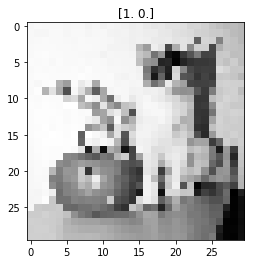

In [17]:
i = 20

plt.imshow(X_train[i].reshape(30,30), cmap='gray')
plt.title(y_train[i])
plt.show()

In [24]:
##create model
model = Sequential()

#add model layers
model.add(Conv2D(20, kernel_size=(5,5), activation='relu', input_shape=X_train[0].shape))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.2))

model.add(Conv2D(40, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(60, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 20)        520       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 40)        7240      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 40)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 40)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 60)          9660      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 60)          0         
__________

In [27]:
output = model.fit(X_train, y_train, epochs=20)

Epoch 1/20
23262/23262 [==============================] - 21s 917us/step - loss: 0.8821 - acc: 0.5313
Epoch 2/20
23262/23262 [==============================] - 21s 894us/step - loss: 0.6755 - acc: 0.5748
Epoch 3/20
23262/23262 [==============================] - 25s 1ms/step - loss: 0.6609 - acc: 0.6024
Epoch 4/20
23262/23262 [==============================] - 21s 897us/step - loss: 0.6488 - acc: 0.6230
Epoch 5/20
23262/23262 [==============================] - 21s 913us/step - loss: 0.6293 - acc: 0.6484
Epoch 6/20
23262/23262 [==============================] - 22s 959us/step - loss: 0.6163 - acc: 0.6632
Epoch 7/20
23262/23262 [==============================] - 23s 1ms/step - loss: 0.6033 - acc: 0.6775
Epoch 8/20
23262/23262 [==============================] - 20s 870us/step - loss: 0.5908 - acc: 0.6861
Epoch 9/20
23262/23262 [==============================] - 20s 862us/step - loss: 0.5810 - acc: 0.6972
Epoch 10/20
23262/23262 [==============================] - 20s 858us/step - loss: 0.57